In [2]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna
from scipy.interpolate import RegularGridInterpolator

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/6w/2tdqp9m179gg5blnzww9hgjc0000gn/T/ipykernel_86905/4184233298.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Inputs 
ac_lst = ['stca', 'a10']
case_lst = ['V2', 'Vmax']
trajectory_lst = ['stcb_base', 'stcb_adv', 'ptcb', 'phld']

z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444


In [4]:
# Load 
stcb_sweeps = dict()
ptcb_sweeps = dict()
idx_stcb_control = dict()
stcb_control = dict()
traj = dict()
epnl = dict()

for ac_name in ac_lst:
    
    stcb_sweeps[ac_name] = dict()
    ptcb_sweeps[ac_name] = dict()
    idx_stcb_control[ac_name] = dict()
    stcb_control[ac_name] = dict()
    traj[ac_name] = dict()
    epnl[ac_name] = dict()
    
    for case in case_lst:

        # Start of sideline noise 
        if ac_name == 'stca' and case == 'V2':
            start = 28
        elif ac_name == 'stca' and case == 'Vmax':
            start = 46
        elif ac_name == 'a10' and case == 'V2':
            start = 64
        elif ac_name == 'a10' and case == 'Vmax':
            start = 76
                        
        # Load STCB sweeps
        stcb_sweeps[ac_name][case] = dict()

        stcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_sideline.npy') 
        stcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_flyover.npy')     
        stcb_sweeps[ac_name][case]['lateral']  = np.max(stcb_sweeps[ac_name][case]['sideline'][:,:,start:], axis=2)
        stcb_sweeps[ac_name][case]['takeoff']  = stcb_sweeps[ac_name][case]['lateral'] + stcb_sweeps[ac_name][case]['flyover'] 

        # Load PTCB sweeps
        ptcb_sweeps[ac_name][case] = dict()
        if ac_name == 'stca' or ac_name == 'a10':
            ptcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_sideline.npy') 
            ptcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_flyover.npy') 
            ptcb_sweeps[ac_name][case]['lateral']  = np.max(ptcb_sweeps[ac_name][case]['sideline'][20:])
            ptcb_sweeps[ac_name][case]['takeoff']  = ptcb_sweeps[ac_name][case]['lateral'] + ptcb_sweeps[ac_name][case]['flyover']

        # Get index of key STCB controls
        idx_stcb_control[ac_name][case] = dict()
        epnl_sub = np.copy(stcb_sweeps[ac_name][case]['takeoff'])
        epnl_sub[:10, :] = 1000*np.ones((10, epnl_sub.shape[1]))
        idx_stcb_control[ac_name][case]['std'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)
        epnl_sub = stcb_sweeps[ac_name][case]['takeoff'][:10, :]
        idx_stcb_control[ac_name][case]['adv'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)

        # Get key STCB controls
        stcb_control[ac_name][case] = dict()
        stcb_control[ac_name][case]['z_cb'] = dict()
        stcb_control[ac_name][case]['TS_cb'] = dict()
        stcb_control[ac_name][case]['z_cb']['std'] = z_cb_lst[idx_stcb_control[ac_name][case]['std'][0]]
        stcb_control[ac_name][case]['z_cb']['adv'] = z_cb_lst[idx_stcb_control[ac_name][case]['adv'][0]]
        stcb_control[ac_name][case]['TS_cb']['std'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['std'][1]]
        stcb_control[ac_name][case]['TS_cb']['adv'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['adv'][1]]
        
        # Get epnl
        epnl[ac_name][case] = dict()
        epnl[ac_name][case]['lateral'] = np.zeros(4)
        epnl[ac_name][case]['flyover'] = np.zeros(4)
        epnl[ac_name][case]['takeoff'] = np.zeros(4)
        epnl[ac_name][case]['lateral'][0] = stcb_sweeps[ac_name][case]['lateral'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['flyover'][0] = stcb_sweeps[ac_name][case]['flyover'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['takeoff'][0] = stcb_sweeps[ac_name][case]['takeoff'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['lateral'][1] = stcb_sweeps[ac_name][case]['lateral'][idx_stcb_control[ac_name][case]['adv']]
        epnl[ac_name][case]['flyover'][1] = stcb_sweeps[ac_name][case]['flyover'][idx_stcb_control[ac_name][case]['adv']]
        epnl[ac_name][case]['takeoff'][1] = stcb_sweeps[ac_name][case]['takeoff'][idx_stcb_control[ac_name][case]['adv']]
        
        if ac_name == 'stca' or ac_name == 'a10':
            epnl[ac_name][case]['lateral'][2] = ptcb_sweeps[ac_name][case]['lateral']
            epnl[ac_name][case]['flyover'][2] = ptcb_sweeps[ac_name][case]['flyover']
            epnl[ac_name][case]['takeoff'][2] = ptcb_sweeps[ac_name][case]['takeoff']
        else:
            epnl[ac_name][case]['lateral'][2] = np.nan
            epnl[ac_name][case]['flyover'][2] = np.nan
            epnl[ac_name][case]['takeoff'][2] = np.nan
        
        epnl[ac_name][case]['lateral'][3] = np.nan
        epnl[ac_name][case]['flyover'][3] = np.nan
        epnl[ac_name][case]['takeoff'][3] = np.nan
        
        epnl[ac_name][case]['sideline'] = dict()
        epnl[ac_name][case]['sideline']['std'] = stcb_sweeps[ac_name][case]['sideline'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['sideline']['adv'] = stcb_sweeps[ac_name][case]['sideline'][idx_stcb_control[ac_name][case]['adv']]
        
        if ac_name == 'stca' or ac_name == 'a10':
            epnl[ac_name][case]['sideline']['ptcb'] = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '/epnl_sideline.npy') 
        
        # Get trajectories
        traj[ac_name][case] = dict()
        traj[ac_name][case]['std'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['std'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['std'], 3))+'.csv')
        traj[ac_name][case]['adv'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['adv'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['adv'], 3))+'.csv')

        if ac_name == 'stca' or ac_name == 'a10':
            traj[ac_name][case]['ptcb'] = pd.read_csv('../cases/'+ac_name+'/trajectory/PTCB/'+case+'/trajectory_'+ac_name+'_ptcb_'+case+'.csv')

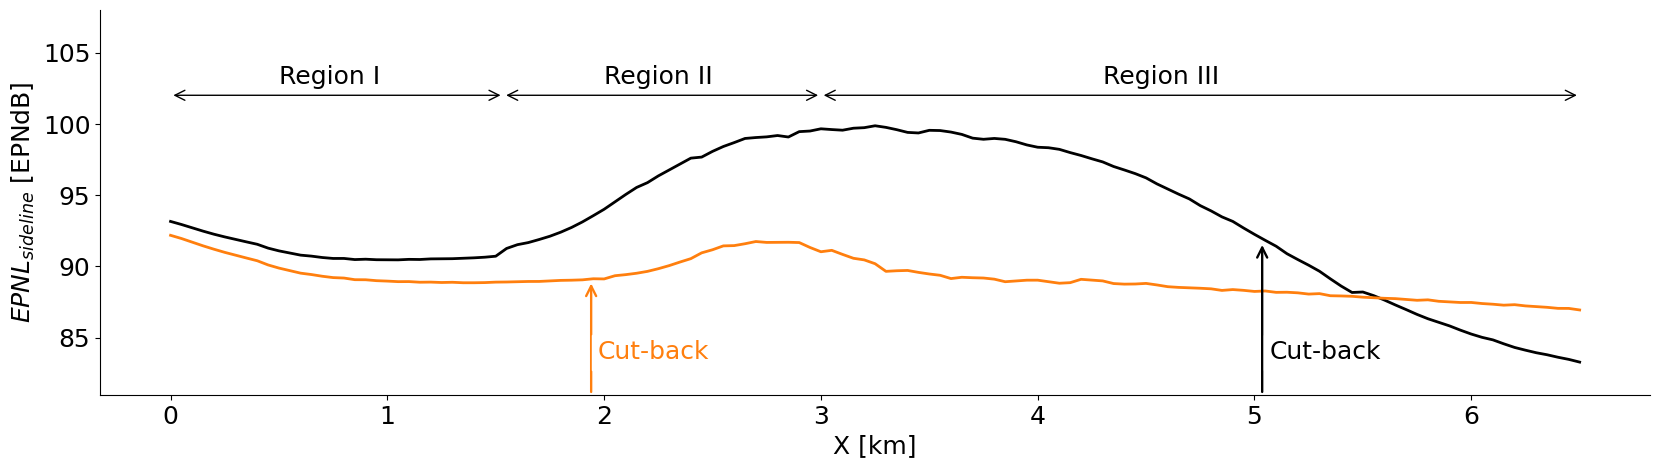

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
plt.style.use('../src/plot.mplstyle')
ax.plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['Vmax']['sideline']['std'], color='k', label='High-altitude STCB')  
ax.plot(np.linspace(0, 6500, 131)/1000, epnl['stca']['Vmax']['sideline']['adv'], color='tab:orange', label='High-altitude STCB')    
ax.set_ylim([81, 108])
ax.set_ylabel('$EPNL_{sideline}$ [EPNdB]')
ax.set_xlabel('X [km]')

x_liftoff = traj['stca']['V2']['std']['X [m]'][np.where(traj['stca']['V2']['std']['Z [m]']>0.1)[0][0]]/1000
# ax.plot([x_liftoff, x_liftoff], [81, 108], '-', color='k', linewidth=1)

x_cb = traj['stca']['V2']['std']['X [m]'][np.where(traj['stca']['V2']['std']['TS [-]']<0.78)[0][0]]/1000
ax.annotate("", xy=(x_cb, 81), xycoords='data', xytext=(x_cb, 91.7), textcoords='data', arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color='k', linewidth=1.7), fontsize=18)


x_cb = traj['stca']['V2']['adv']['X [m]'][np.where(traj['stca']['V2']['adv']['TS [-]']<0.78)[0][0]]/1000
ax.annotate("", xy=(x_cb, 81), xycoords='data', xytext=(x_cb, 89), textcoords='data', arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color='tab:orange', linewidth=1.7), fontsize=18, )


ax.annotate("", xy=(0, 102), xycoords='data', xytext=(x_liftoff, 102), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"), fontsize=18)
ax.annotate("", xy=(x_liftoff, 102), xycoords='data', xytext=(3, 102), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"), fontsize=18)
ax.annotate("", xy=(3, 102), xycoords='data', xytext=(6.5, 102), textcoords='data', arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"), fontsize=18)

ax.annotate(xy=(0.5, 102.8), text="Region I", fontsize=18)
ax.annotate(xy=(2.0, 102.8), text="Region II", fontsize=18)
ax.annotate(xy=(4.3, 102.8), text="Region III", fontsize=18)

# ax.annotate(xy=(1.1, 83.5), text='Lift-off', fontsize=18, backgroundcolor='w', color='k')
ax.annotate(xy=(5.07, 83.5), text='Cut-back', fontsize=18, backgroundcolor='w', color='k')
ax.annotate(xy=(1.97, 83.5), text='Cut-back', fontsize=18, backgroundcolor='w', color='tab:orange')

ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.legend(loc='lower left', bbox_to_anchor=(0,0.98), frameon=False, ncol=2)

